In [39]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D

#
import plotly.graph_objects as go
import plotly.express as px

In [40]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('GVR Historical Data.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,"18,900","18,950","19,000","18,600",2.72M,0.53%
1,06/01/2023,"18,800","18,350","18,900","18,100",4.25M,3.30%
2,05/31/2023,"18,200","18,450","18,450","18,000",3.14M,-1.09%
3,05/30/2023,"18,400","18,300","18,500","17,850",4.58M,1.10%
4,05/29/2023,"18,200","17,200","18,200","17,050",6.08M,5.81%
...,...,...,...,...,...,...,...
1287,03/28/2018,"11,327","10,736","11,622","10,637",139.80K,5.50%
1288,03/27/2018,"10,736","10,637","10,834","10,342",52.20K,5.83%
1289,03/26/2018,"10,145","10,046","10,342","10,046",267.80K,-1.90%
1290,03/23/2018,"10,342","10,440","10,440","9,849",111.80K,-3.67%


In [41]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [42]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,18900.0,18950.0,19000.0,18600.0,2720000.0,0.0053
1,2023-06-01,18800.0,18350.0,18900.0,18100.0,4250000.0,0.0330
2,2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109
3,2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
4,2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
...,...,...,...,...,...,...,...
1287,2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
1288,2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
1289,2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
1290,2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367


In [43]:
df=df.sort_values(['Date'])
df1=df.reset_index()['Price']
df

,Date,Price,Open,High,Low,Vol.,Change %
1291,2018-03-22,10736.0,10834.0,11130.0,10046.0,260800.0,0.0000
1290,2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367
1289,2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
1288,2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
1287,2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
...,...,...,...,...,...,...,...
4,2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
3,2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
2,2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109
1,2023-06-01,18800.0,18350.0,18900.0,18100.0,4250000.0,0.0330


In [44]:
df.describe()


,Price,Open,High,Low,Vol.,Change %
count,1292.000000,1292.00000,1292.000000,1292.000000,1.292000e+03,1292.000000
mean,18318.022446,18331.44582,18721.491486,17966.616873,2.053196e+06,0.000922
std,9337.694144,9357.29766,9544.342849,9185.488125,2.092621e+06,0.031147
min,6796.000000,7190.00000,7683.000000,6599.000000,3.000000e+02,-0.137600
25%,11122.500000,11100.00000,11400.000000,10834.000000,3.637350e+05,-0.014725
50%,14200.000000,14250.00000,14506.000000,13914.000000,1.430000e+06,0.000000
75%,25031.000000,25055.25000,25579.000000,24410.250000,2.985000e+06,0.017675
max,41004.000000,42173.00000,42173.000000,39738.000000,1.585000e+07,0.168500


In [45]:
fig = px.line(df, x=df.Date, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of GVR', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [46]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [47]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [48]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [49]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [50]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [51]:
# 8.
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a LSTM layer
model.add(LSTM(100, activation='relu'))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [52]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 5s 169ms/step - loss: 0.0901 - val_loss: 0.0178
Epoch 2/100
13/13 [==============================] - 1s 90ms/step - loss: 0.0134 - val_loss: 0.0073
Epoch 3/100
13/13 [==============================] - 1s 100ms/step - loss: 0.0057 - val_loss: 0.0095
Epoch 4/100
13/13 [==============================] - 2s 129ms/step - loss: 0.0034 - val_loss: 0.0165
Epoch 5/100
13/13 [==============================] - 2s 174ms/step - loss: 0.0029 - val_loss: 0.0114
Epoch 6/100
13/13 [==============================] - 1s 88ms/step - loss: 0.0026 - val_loss: 0.0081
Epoch 7/100
13/13 [==============================] - 1s 90ms/step - loss: 0.0023 - val_loss: 0.0094
Epoch 8/100
13/13 [==============================] - 2s 155ms/step - loss: 0.0023 - val_loss: 0.0088
Epoch 9/100
13/13 [==============================] - 2s 136ms/step - loss: 0.0022 - val_loss: 0.0107
Epoch 10/100
13/13 [==============================] - 1s 88ms/step - loss: 0.0021 - val_loss: 

In [53]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 28ms/step


In [54]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [55]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 16160.184853934583
Testing RMSE: 23373.82303187578


In [56]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.35822514]
101
1 day input [0.23690365 0.22228718 0.22228718 0.22228718 0.22521048 0.23398036
 0.22667212 0.24567353 0.26175164 0.26905987 0.27782975 0.29390786
 0.28367633 0.28952292 0.25590505 0.24713517 0.25152011 0.2573667
 0.23398036 0.23251871 0.23836529 0.22959542 0.21059401 0.21497895
 0.22521048 0.23251871 0.23105706 0.25298176 0.25005847 0.22667212
 0.23398036 0.21936389 0.20913237 0.20913237 0.22228718 0.21790225
 0.21351731 0.2164406  0.22228718 0.22521048 0.24421188 0.23982694
 0.23836529 0.21936389 0.24567353 0.235442   0.23690365 0.22082554
 0.22374883 0.22521048 0.22521048 0.23398036 0.23690365 0.23398036
 0.23251871 0.23105706 0.25444341 0.26759822 0.26759822 0.27490645
 0.2573667  0.26613658 0.26613658 0.2763681  0.27929139 0.26759822
 0.24859682 0.25152011 0.25444341 0.24128859 0.24421188 0.24275023
 0.24859682 0.24275023 0.25005847 0.25298176 0.25590505 0.26028999
 0.25444341 0.27490645 0.27344481 0.29390786 0.28952292 0.29244621
 0.27344481 0.26905987 0.26467493 

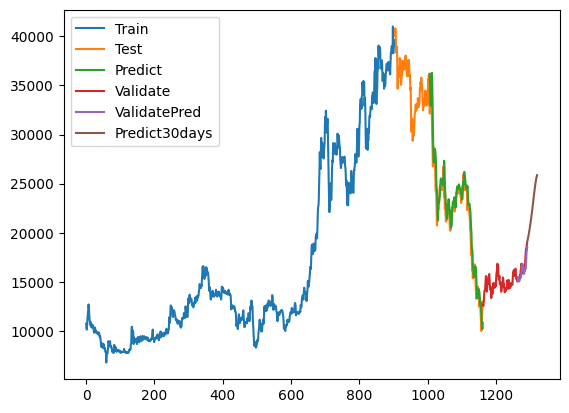

In [57]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()